In [3]:
import numpy as np
from svm_classifier import svm, svm_angular
from knn_classifier import k_nn
from time import time
import pandas as pd
from ctypes import *
import sys
from math import sqrt as sqrt

lib = cdll.LoadLibrary("./naivelib.so")


class cross_validation_result(Structure):
    _fields_ = [    ("avg_accuracy", c_float),
                    ("min_accuracy", c_float),
                    ("max_accuracy", c_float),
                    ("accuracy_variance", c_float) ]
    def __init__(self):
        self.avg_accuracy = self.accuracy_variance = 0;
        self.min_accuracy = sys.float_info.max;
        self.max_accuracy = sys.float_info.min;
    
    def print_scores(self):
        print( "==========================================================" + "\n" 
                + "Naive bayes classification: " + "\n" 
                + "Minimum Accuracy: " + str(self.min_accuracy) + "\n"
                + "Average Accuracy: " + str(self.avg_accuracy) + "\n"
                + "Maximum Accuracy: " + str(self.max_accuracy) + "\n"
                + "Variance of Accuracy: " + str(self.accuracy_variance) + "\n"
                + "Standard Deviation of Accuracy: " + str(sqrt(self.accuracy_variance)) + "\n" 
                + "=========================================================="
        )



# Load spambase dataset
file_name = "spambase.data"
data = open(file_name, "r")
mailData = np.loadtxt(data, delimiter=",")
np.random.shuffle(mailData)


# MAIN:

lib.py_main.restype = cross_validation_result
start = time()
naive_bayes_score = lib.py_main()
end = time()
naive_bayes_time = end - start

# naive_bayes_score.print_scores()

start = time()
linear_score, poly_score, rbf_score = svm(mailData)
end = time()
svm_time = end - start
# print("\nTime elapsed for SVM: {}".format(end - start))

start = time()
linear_norm_score, poly_norm_score, rbf_norm_score = svm_angular(mailData)
end = time()
svm_norm_time = end - start
# print("\nTime elapsed for SVM Angular: {}".format(end - start))

start = time()
knn_score = k_nn(mailData)
end = time()
knn_time = end - start
# print("\nTime elapsed for K-NN: {}".format(end - start))


minimum_accuracy = [
    linear_score.min() * 100,
    poly_score.min() * 100,
    rbf_score.min() * 100,
    linear_norm_score.min() * 100,
    poly_norm_score.min() * 100,
    rbf_norm_score.min() * 100,
    knn_score.min() * 100,
    naive_bayes_score.min_accuracy * 100 
]
average_accuracy = [
    linear_score.mean() * 100,
    poly_score.mean() * 100,
    rbf_score.mean() * 100,
    linear_norm_score.mean() * 100,
    poly_norm_score.mean() * 100,
    rbf_norm_score.mean() * 100,
    knn_score.mean() * 100,
    naive_bayes_score.avg_accuracy * 100
]
maximum_accuracy = [
    linear_score.max() * 100,
    poly_score.max() * 100,
    rbf_score.max() * 100,
    linear_norm_score.max() * 100,
    poly_norm_score.max() * 100,
    rbf_norm_score.max() * 100,
    knn_score.max() * 100,
    naive_bayes_score.max_accuracy * 100 
]
elapsed_time = [
    str(round(svm_time, 4)) + " (For all SVMs)",
    str(round(svm_time, 4)) + " (For all SVMs)",
    str(round(svm_time, 4)) + " (For all SVMs)",
    str(round(svm_norm_time, 4)) + " (For all Norm SVMs)",
    str(round(svm_norm_time, 4)) + " (For all Norm SVMs)",
    str(round(svm_norm_time, 4)) + " (For all Norm SVMs)",
    str(round(knn_time, 4)),
    str(round(naive_bayes_time, 4))
]
variance_of_accuracy= [
    linear_score.var(),
    poly_score.var(),
    rbf_score.var(),
    linear_norm_score.var(),
    poly_norm_score.var(),
    rbf_norm_score.var(),
    knn_score.var(),
    naive_bayes_score.accuracy_variance]
std_of_accuracy = [linear_score.std(),
    poly_score.std(),
    rbf_score.std(),
    linear_norm_score.std(),
    poly_norm_score.std(),
    rbf_norm_score.std(),
    knn_score.std(),
    sqrt(naive_bayes_score.accuracy_variance)]
index = [
    "Linear SVM",
    "2-degree Poly SVM",
    "RBF SVM",
    "Linear Norm SVM",
    "2-degree Poly Norm SVM",
    "RBF Norm SVM",
    "KNN",
    "NAIVE BAYES"
]
dfTable = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
        "Variance of Accuracy": variance_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "elapsed_time": elapsed_time
    },
    index=index
)

dfTable



Elapsed time = 0.078017 seconds.
Minimum Accuracy: 0.819172
Average Accuracy: 0.850142
Maximum Accuracy: 0.897604
Variance of Accuracy: 0.00544547
Standard Deviation of Accuracy: 0.0737934


,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,elapsed_time
Linear SVM,60.434783,60.834622,61.086957,0.000003,0.001833,12.0636\n(For all SVMs)
2-degree Poly SVM,78.913043,81.004338,83.260870,0.000172,0.013127,12.0636\n(For all SVMs)
RBF SVM,90.000000,92.371027,94.130435,0.000152,0.012325,12.0636\n(For all SVMs)
Linear Norm SVM,89.782609,92.675375,94.130435,0.000172,0.013124,5.049\n(For all Norm SVMs)
2-degree Poly Norm SVM,91.521739,93.957465,95.661605,0.000178,0.013335,5.049\n(For all Norm SVMs)
RBF Norm SVM,92.173913,93.892483,95.434783,0.000132,0.011488,5.049\n(For all Norm SVMs)
KNN,88.913043,91.218900,93.058568,0.000132,0.011494,0.5391
NAIVE BAYES,81.917208,85.014212,89.760351,0.005445,0.073793,0.1322


Now follows the graphical comparison:

(0.0, 100.0)

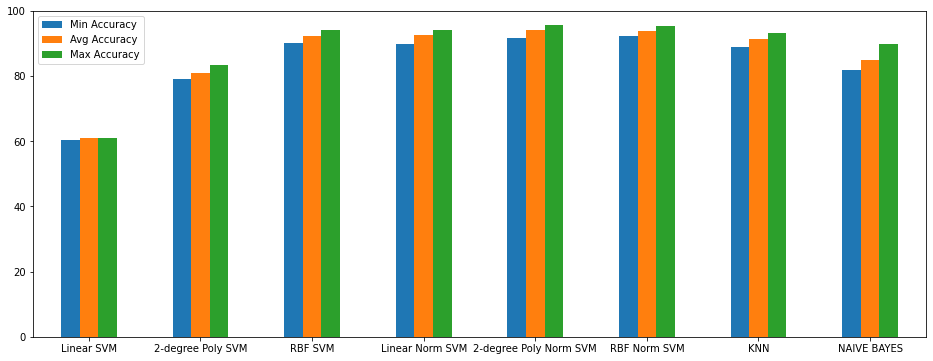

In [4]:
minimum_accuracy = [
    linear_score.min() * 100,
    poly_score.min() * 100,
    rbf_score.min() * 100,
    linear_norm_score.min() * 100,
    poly_norm_score.min() * 100,
    rbf_norm_score.min() * 100,
    knn_score.min() * 100,
    naive_bayes_score.min_accuracy * 100 
]
average_accuracy = [
    linear_score.mean() * 100,
    poly_score.mean() * 100,
    rbf_score.mean() * 100,
    linear_norm_score.mean() * 100,
    poly_norm_score.mean() * 100,
    rbf_norm_score.mean() * 100,
    knn_score.mean() * 100,
    naive_bayes_score.avg_accuracy * 100
]
maximum_accuracy = [
    linear_score.max() * 100,
    poly_score.max() * 100,
    rbf_score.max() * 100,
    linear_norm_score.max() * 100,
    poly_norm_score.max() * 100,
    rbf_norm_score.max() * 100,
    knn_score.max() * 100,
    naive_bayes_score.max_accuracy * 100 
]
index = [
    "Linear SVM",
    "2-degree Poly SVM",
    "RBF SVM",
    "Linear Norm SVM",
    "2-degree Poly Norm SVM",
    "RBF Norm SVM",
    "KNN",
    "NAIVE BAYES"
]
df = pd.DataFrame(
    {
        "Min Accuracy": minimum_accuracy,
        "Avg Accuracy": average_accuracy,
        "Max Accuracy": maximum_accuracy,
    },
    index=index
)


ax = df.plot.bar(rot=0, figsize=(16,6))
ax.set_ylim(0, 100)